### todo
- proactive interference 
    - trial unique stimuli should not yield PI
- going forward with n-back: don't flush cell between trials, and include instruction for which n at beginning of trial. 

In [1]:
from datetime import datetime as dt
from glob import glob as glob
import torch as tr
import numpy as np
import itertools

from Nback_tasks import NbackTask_PureEM
from Nback_models import PureEM

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size':22})

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


# TODO 
- fpath2model
- model_analysis

### load model

In [2]:
def load_net_fpath(fpath):
  net = PureEM(indim=15,stsize=25)
  net.load_state_dict(tr.load(fpath))
  return net

def load_group_fpathL(fpathL):
  netL = []
  for fpath in fpathL:
    netL.append(load_net_fpath(fpath))
  return netL

def glob_fpathL(nback,ntokens,seed='*'):
  dirpath = "model_data/pureEM-sweep2"
  glob_fpath = dirpath + "/pureEM_25-ntokens_%s-nback_%s-seed_%s-model.pt" %(ntokens,nback,seed)
  fpathL = glob(glob_fpath)
  return fpathL

def load_net(nback,ntokens,seed=0):
  dirpath = "model_data/pureEM-sweep2"
  net_fpath = dirpath + "/pureEM_25-ntokens_%s-nback_%s-seed_%s-model.pt" %(ntokens,nback,seed)
  net = load_net_fpath(net_fpath)
  return net

def load_group(nback,ntokens,seed='*'):
  fpathL = glob_fpathL(nback,ntokens,seed)
  netL = load_group_fpathL(fpathL)
  return netL


# set size effect

In [3]:
def eval_netL(netL,task,mthresh=.95):
  gen_rand_trials = lambda: task.gen_ep_data(seqlen)
  eval_acc = np.ones((len(netL),seqlen))
  for idx,net in enumerate(netL):
    net.mthresh=mthresh
    eval_score = run_model(net,500,gen_rand_trials,training=False,verb=False)
    eval_acc[idx] = eval_score.mean(0)
  return eval_acc

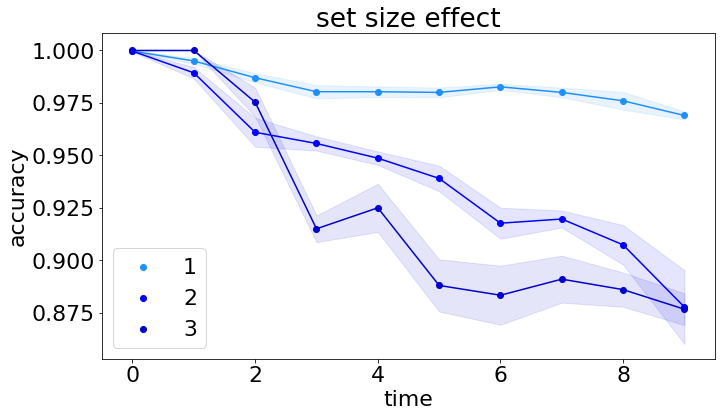

In [167]:
plt.figure(figsize=(11,6))
ax = plt.gca()

ntokens = 10

cL = ['dodgerblue','blue','mediumblue']

for nback in [1,2,3]:
  task = NbackTask_PureEM(nback=nback,ntokens=ntokens,cdrift=.5,cdim=5,sedim=10)
  netL = load_group(nback=nback,ntokens=ntokens,seed='*')
  acc = eval_netL(netL,task)
  M = acc.mean(0)
  S = acc.std(0)/np.sqrt(len(acc))
  ax.plot(M,color=cL[nback-1])
  ax.scatter(range(len(M)),M,label=nback,color=cL[nback-1])
  ax.fill_between(range(len(M)),M-S,M+S,alpha=.1,color=cL[nback-1])
plt.legend()
ax.set_xlabel('time')
ax.set_ylabel('accuracy')
ax.set_title('set size effect')
plt.savefig('figures/setsize_line')

In [130]:
task = NbackTask_PureEM(nback=nback,ntokens=ntokens,cdrift=.5,cdim=5,sedim=10)
netL = load_group(nback=nback,ntokens=ntokens,seed='*')
acc = eval_netL(netL,task)

In [168]:
ML = []
SL = []
for nback in [1,2,3]:
  task = NbackTask_PureEM(nback=nback,ntokens=ntokens,cdrift=.5,cdim=5,sedim=10)
  netL = load_group(nback=nback,ntokens=ntokens,seed='*')
  acc = eval_netL(netL,task)
  M = acc[:,3:].mean()
  ML.append(M)
  S = acc.mean(1).std(0)/np.sqrt(len(acc))
  SL.append(S)

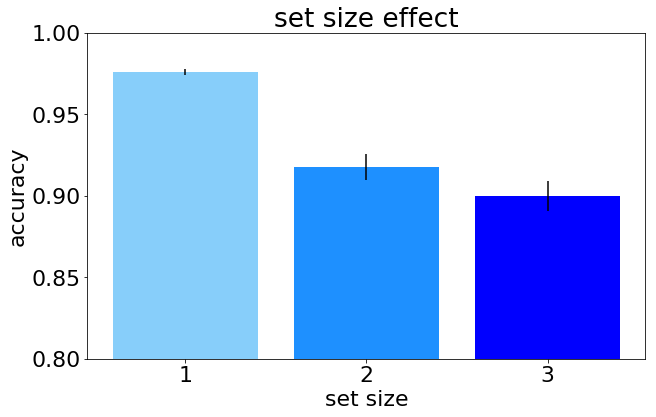

In [170]:
plt.figure(figsize=(10,6))
ax = plt.gca()
cL = ['lightskyblue','dodgerblue','b']
ax.bar(np.arange(len(ML))+1,ML,yerr=2*np.array(SL),color=cL)
ax.set_ylim(0.8,1)
ax.set_xlabel('set size')
ax.set_ylabel('accuracy')
ax.set_title('set size effect')
ax.set_xticks(range(1,4))
plt.savefig('figures/setsize_bar')

## retrieval rate as a function of number of tokens 

In [3]:
def calc_retrieval_count(net,task,nitr=1000):
  """ 
  retrieval count of the net on the last trial
  returns 1D array with num of retrievals on last trial
  """
  trial_len = 10
  retrieval_count = -np.ones(nitr)
  for itr in range(nitr):
    context,stim,yhat=task.gen_ep_data(trial_len)
    y = net.forward(context,stim) 
    # count num retrievals on last trials
    query = tr.cat([context[-1],stim[-1]],dim=-1)
    num_retrievals = len(net.retrieve(query))
    retrieval_count[itr] = num_retrievals
  return retrieval_count

def calc_retrieval_rate_netL(netL,task):
  """
  give a list of networks and a task
  calculates the retrieval for each network on last trial
  """
  rrate_arr = -np.ones(len(netL))
  for idx,net in enumerate(netL):
    rcount = calc_retrieval_count(net,task,1000)
    rrate_arr[idx] = rcount.mean()
  return rrate_arr

## loops

def calc_retrieval_rate_netL_loop(netL,ntokens_evL=[3,20],ntokens_tr=3,nback=2):
  """ 
  loop over eval ntokens
  """
  data_arr = -np.ones((len(netL),len(ntokens_evL)))
  for idx,ntokens_ev in enumerate(ntokens_evL):
    task = NbackTask_PureEM(nback=nback,ntokens=ntokens_ev,cdrift=.5,cdim=5,sedim=10)
    data_arr[:,idx] = calc_retrieval_rate_netL(netL,task)
  return data_arr

def calc_retrieval_rate_netL_loop2(ntokens_trL=[3,10],ntokens_evL=[3,20],ntokens_tr=3,nback=2):
  """ 
  loop over train and eval ntokens
  returns (net,tr_ntokens,)
  """
  netL_ = load_group(2,3,seed='*')
  data_arr = -np.ones((len(netL_),len(ntokens_trL),len(ntokens_evL)))
  for idx,ntokens_tr in enumerate(ntokens_trL):
    netL = load_group(nback,ntokens_tr,seed='*')
    data_arr[:,idx,:] = calc_retrieval_rate_netL_loop(netL,ntokens_evL=ntokens_evL,ntokens_tr=ntokens_tr,nback=2)
  return data_arr

In [5]:
data_arr = calc_retrieval_rate_netL_loop2(ntokens_trL=[3,10],ntokens_evL=[3,5,20],ntokens_tr=3,nback=2)

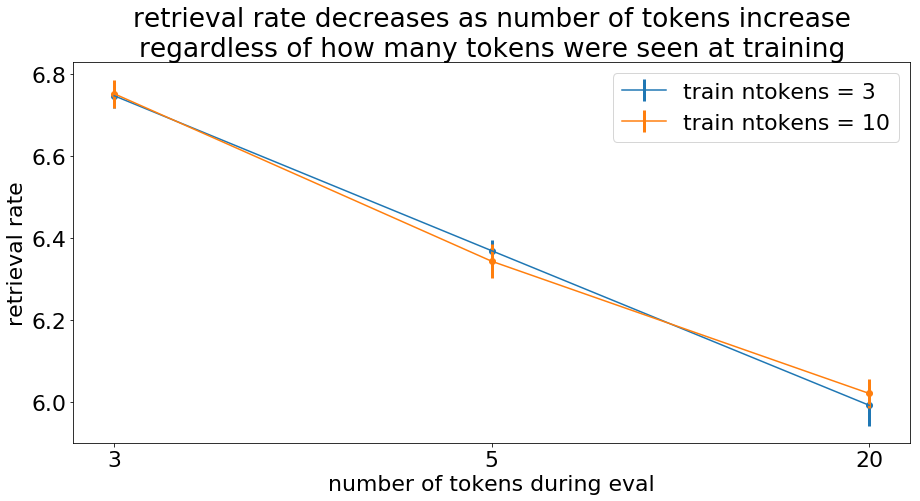

In [6]:
plt.figure(figsize=(15,7))
ax = plt.gca()

M = data_arr.mean(0)
S = data_arr.std(0)
labL = ['train ntokens = 3','train ntokens = 10']
for idx,(m,s) in enumerate(zip(M,S)):
  ax.scatter(range(len(m)),m)
  ax.errorbar(range(len(m)),m,yerr=s,elinewidth=3,label=labL[idx])

ax.set_xticks([0,1,2])
ax.set_xticklabels([3,5,20])
ax.set_ylabel('retrieval rate')
ax.set_xlabel('number of tokens during eval')
ax.set_title('retrieval rate decreases as number of tokens increase\nregardless of how many tokens were seen at training')
plt.legend()
# plt.savefig('figures/rrate-vs-ntokens')

## the above results show that retrieval rate changes as a function of number of tokens in the eval session, but not number of tokens the network was trained on. 

# Proactive interference
- plot accuracy on last trial as a function of number of ntokens during eval

In [171]:
def run_model(net,neps,gen_data_fn,training=False,verb=False):
  """ 
  used for training or eval
  gen_data_fn: callable that generates a trial of data (embedded)
  """
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=0.001)
  # data generating option:
  C,X,Y = gen_data_fn()
  seqlen = len(C)
  # loop
  score = -np.ones([neps,seqlen])    
  for ep in range(neps):
    if ep%(neps/10)==0:
      if verb:print(ep/neps)
    # gen stim
    context,stim,ytarget = gen_data_fn()
    # forward prop
    yhat = net(context,stim)
    score[ep] = tr.argmax(tr.softmax(yhat,-1),-1).squeeze() == ytarget
    mif training:
      for tstep in range(seqlen):
        loss = lossop(yhat[tstep],ytarget[:,tstep])
        optiop.zero_grad()
        loss.backward(retain_graph=True)
        optiop.step()
  return score

In [172]:
seqlen=10

In [173]:
def eval_netL(netL,task,mthresh=.95):
  gen_rand_trials = lambda: task.gen_ep_data(seqlen)
  eval_acc = np.ones((len(netL),seqlen))
  for idx,net in enumerate(netL):
    net.mthresh=mthresh
    eval_score = run_model(net,500,gen_rand_trials,training=False,verb=False)
    eval_acc[idx] = eval_score.mean(0)
  return eval_acc


In [174]:
nback = 2
mthresh = .95
netL = load_group(nback=nback,ntokens=10,seed='*')
ntokens_evL = [3,10]
data_arr = -np.ones((len(ntokens_evL),len(netL),seqlen))
for idx,ntokens_ev in enumerate(ntokens_evL):
  task = NbackTask_PureEM(nback=nback,ntokens=ntokens_ev,cdrift=.3,cdim=5,sedim=10)
  eval_acc = eval_netL(netL,task,mthresh)
  data_arr[idx] = eval_acc

In [175]:
data_arr.shape

(2, 6, 10)

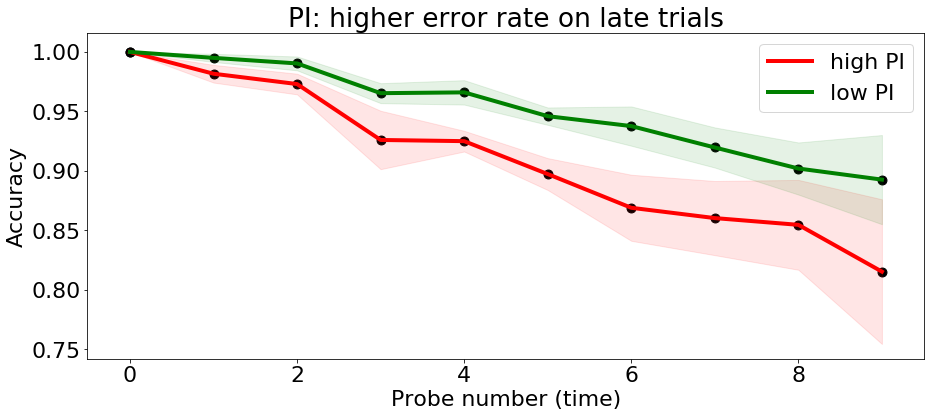

In [187]:
plt.figure(figsize=(15,6))
ax = plt.gca()
M = data_arr.mean(1)
S = data_arr.std(1)
cL=['r','g']
labL=['high PI','low PI']
for idx,(m,s) in enumerate(zip(M,S)):
  ax.plot(m,c=cL[idx],label=labL[idx],lw=4)
  ax.scatter(range(len(m)),m,c='k',s=80)
  ax.fill_between(range(len(m)),m+s,m-s,alpha=.1,color=cL[idx])
plt.legend()
ax.set_ylabel('Accuracy')
ax.set_xlabel('Probe number (time)')
ax.set_title('PI: higher error rate on late trials')
plt.savefig('figures/proactive_interference')

# NB
- task used to have a main method that I would always use to generate data
- to allow for flexibility, I'm going to start using it as a modular package that allows generating data in different ways

## intrusion probe

In [38]:
nback = 3
ntokens = 10
net = load_net(nback,ntokens,seed=4)
task = NbackTask_PureEM(nback=nback,ntokens=ntokens,cdrift=.5,cdim=5,sedim=10)

In [39]:
def gen_seq(seqtail,head_len=4,ntokens=3):
  """ 
  given the tail of a sequence
  randomly samples many heads
  """
  seqtail = np.array(seqtail)
  seqhead = np.random.randint(0,ntokens,head_len)
  seq = np.concatenate([seqhead,seqtail])
  return seq

def run_model(net,neps,gen_data_fn,training=False,verb=False):
  """ 
  used for training or eval
  gen_data_fn: callable that generates a trial of data (embedded)
  """
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=0.001)
  # data generating option:
  C,X,Y = gen_data_fn()
  seqlen = len(C)
  # loop
  score = -np.ones([neps,seqlen])    
  for ep in range(neps):
    if ep%(neps/10)==0:
      if verb:print(ep/neps)
    # gen stim
    context,stim,ytarget = gen_data_fn()
    # forward prop
    yhat = net(context,stim)
    score[ep] = tr.argmax(tr.softmax(yhat,-1),-1).squeeze() == ytarget
    if training:
      for tstep in range(seqlen):
        loss = lossop(yhat[tstep],ytarget[:,tstep])
        optiop.zero_grad()
        loss.backward(retain_graph=True)
        optiop.step()
  return score

In [40]:
neps = 300
headlen = 3 
gen_data_fixtail = lambda seqtail: lambda: task.seq2data(gen_seq(seqtail,head_len=headlen))

print('nback =',nback)

cL = ['g','b','purple','r']

seqL = [[0,1,2,0],[0,1,2,3],[0,1,2,2],[1,0,2,0]]

# data
scoreL = [run_model(net,neps,gen_data_fn=gen_data_fixtail(seq)) for seq in seqL]

nback = 3


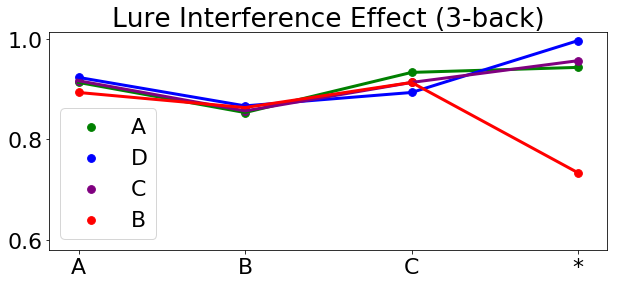

In [44]:
plt.figure(figsize=(10,4))
ax = plt.gca()
labL = ['A',"D","C","B"]
for idx,score in enumerate(scoreL):
  acc = score.mean(0)[headlen:]
  ax.plot(acc,c=cL[idx],lw=3)
  ax.scatter(range(len(acc)),acc,c=cL[idx],label=labL[idx],s=60)

plt.legend()
ax.set_xticks(np.arange(4))
ax.set_xticklabels(['A','B','C','*'])
ax.set_title('Lure Interference Effect (3-back)')
ax.set_ylim(0.58)
plt.savefig('figures/lurePIeffect')

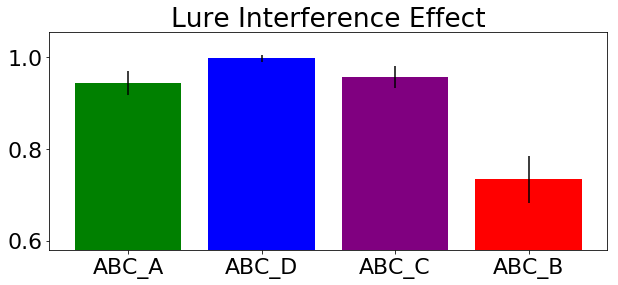

In [46]:
plt.figure(figsize=(10,4))
ax = plt.gca()
score_acc = np.array(scoreL)
M = score_acc.mean(1)
S = 2*score_acc.std(1)/np.sqrt(neps)
labL = ['ABC_A',"ABC_D","ABC_C","ABC_B"]
ax.bar(range(4),M[:,-1],color=cL,yerr=S[:,-1])
ax.set_xticklabels([0]+labL)
ax.set_title('Lure Interference Effect')
ax.set_ylim(0.58)
plt.savefig('figures/lurePIeffect_bar')

# load trained data

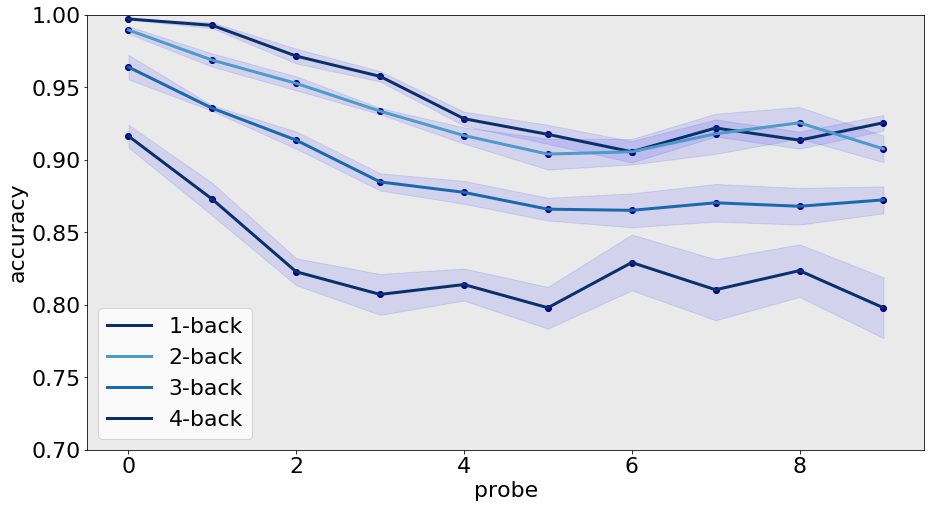

In [11]:
plt.figure(figsize=(15,8))
ax = plt.gca()

nbackL = [1,2,3,4]
driftL = [5]

cL = [plt.get_cmap('Blues')(i) for i in [150,200,300]]
# acc_arr = -np.ones(4,10)
L = []
for drift,nback in itertools.product(driftL,nbackL):
  fpathL = glob('model_data/pureEM-sweep/eval_acc-nback_%i-context_drift_%i-seed_*.npy'%(nback,drift))
  accL = []
  for fpath in fpathL:
    score = np.load(fpath)
    acc = score.mean(0)
    accL.append(acc)
  acc_arr = np.array(accL)
  
  M = acc_arr.mean(0)
  S = acc_arr.std(0)/np.sqrt(len(acc_arr))
  ax.plot(M,label='%i-back'%(nback),lw=3,color=cL[nback-2])
  ax.fill_between(range(len(M)),M-S,M+S,alpha=.1,color='blue')
  ax.scatter(range(len(M)),M,c='darkblue')
  
ax.set_facecolor(plt.get_cmap('Greys')(40))
ax.set_ylabel('accuracy')
ax.set_xlabel('probe')
ax.set_ylim(.7,1)
plt.legend()
# plt.savefig('figures/eval_acc-234back')

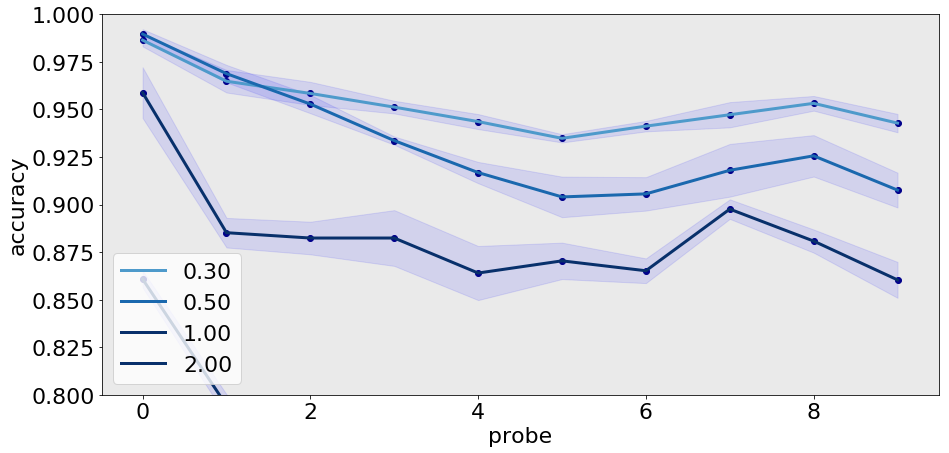

In [10]:
plt.figure(figsize=(15,7))
ax = plt.gca()

nbackL = [2]
driftL = [3,5,10,20]

cL = [plt.get_cmap('Blues')(i) for i in [150,200,300,400]]
# cL = ['r','g','b']
# acc_arr = -np.ones(4,10)
L = []
for idx,(drift,nback) in enumerate(itertools.product(driftL,nbackL)):
  fpathL = glob('model_data/pureEM-sweep/eval_acc-nback_%i-context_drift_%i-seed_*.npy'%(nback,drift))
  accL = []
  for fpath in fpathL:
    score = np.load(fpath)
    acc = score.mean(0)
    accL.append(acc)
  acc_arr = np.array(accL)
  
  M = acc_arr.mean(0)
  S = acc_arr.std(0)/np.sqrt(len(acc_arr))
  ax.plot(M,label='%.2f'%(drift/10),lw=3,color=cL[idx])
  ax.fill_between(range(len(M)),M-S,M+S,alpha=.1,color='blue')
  ax.scatter(range(len(M)),M,c='darkblue')
  
ax.set_facecolor(plt.get_cmap('Greys')(40))
ax.set_ylabel('accuracy')
ax.set_xlabel('probe')
ax.set_ylim(.8,1)
plt.legend()
plt.savefig('figures/eval_acc-bydrift')

## train

In [5]:
## sweeping params
seed = 2
tr.manual_seed(seed)
np.random.seed(seed)

In [8]:
nback=1
ntrials=10+nback
ntokens_og=3
stsize = 30
context_edim = 5
context_drift_std = .5
stim_edim = 10

# ntrials=5
# ntokens_og=3
# stsize = 3
# context_edim = 2
# stim_edim = 2


task = NbackTask_PureEM(ntokens_og,ntrials)
net = PureEM(nback,context_edim+stim_edim,stsize,seed,debug=False)

lossop = tr.nn.CrossEntropyLoss()
optiop = tr.optim.Adam(net.parameters(), lr=0.001)

-- proportion of true trials: M=0.48 S=0.14


In [9]:
nepochs=50000
  
def emb(stim_t_int,context_t_int,stim_emat,context_emat):
  xt_s_emb = stim_emat[stim_t_int].unsqueeze(0)
  xt_c_emb = context_emat[context_t_int].unsqueeze(0)
  xt_emb = tr.cat([xt_s_emb,xt_c_emb],-1) 
  return xt_emb
  
ep_loss = -np.ones([nepochs,ntrials-nback])
A = -np.ones(nepochs)

for ep in range(nepochs):
  if ep%(nepochs/5)==0:
    print(ep/nepochs)
  # embeddings matrices
  context_emat = tr.Tensor(task.generate_context_drift(ntrials,context_edim,context_drift_std))
  stim_emat = tr.randn(ntokens_og,stim_edim)
  # epoch data
  T,X,Y = task.gen_episode_data()
#   print('S=',X)
  X = tr.LongTensor(X)
  Y = tr.LongTensor(Y)
  # initial lstm
  h_t,c_t = tr.zeros(2,1,stsize)
  # initialize memory
  memoryL = []
  for tstep in range(nback):
    xt_emb = emb(X[tstep],tstep,stim_emat,context_emat)
    memoryL.append(xt_emb)
  net.init_memory(memoryL)
  # unroll
  acc = 0
  for tstep in range(nback,ntrials):
    # embed input
    x_t_int = X[tstep]
    xt_emb = emb(X[tstep],tstep,stim_emat,context_emat)
    # fp
    yhat,h_k,c_k = net(xt_emb,h_t,c_t)
    net.encode(xt_emb)
    # bp
    ytarget = Y[tstep].unsqueeze(0)
    loss = lossop(yhat,ytarget)
    ep_loss[ep,tstep-2] = loss.item()
    optiop.zero_grad()
    loss.backward(retain_graph=True)
    optiop.step()
    acc += tr.argmax(tr.softmax(yhat,1),1)==ytarget 
  A[ep] = acc.numpy()/(ntrials-nback)
  


0.0
0.2
0.4
0.6
0.8


In [10]:
def mov_avg(X,wind=20):
  MA = []
  for t in range(X.shape[0]-wind):
    MA.append(np.mean(X[t:t+wind]))
  return np.array(MA)

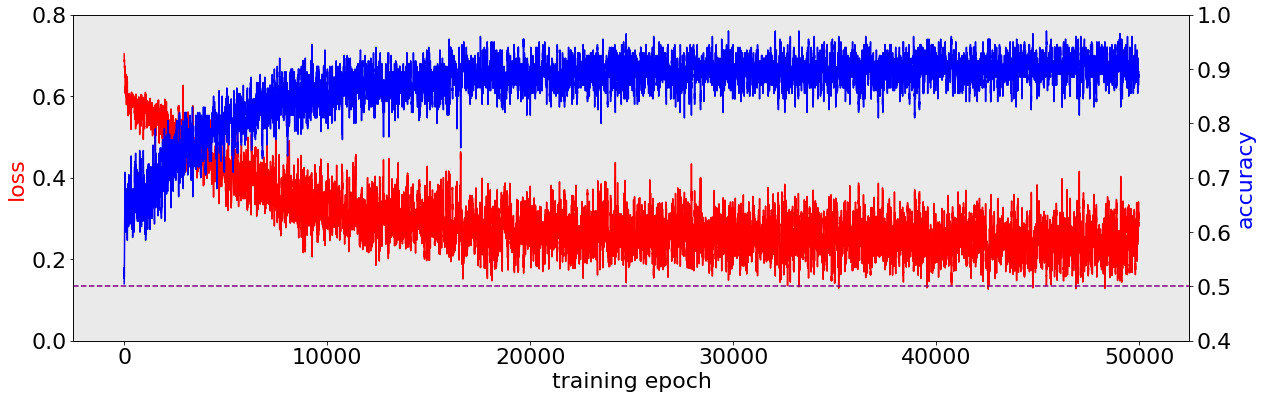

In [12]:
plt.figure(figsize=(20,6))
ax = plt.gca()
ax2 = ax.twinx()

L = ep_loss.mean(1)
ax.plot(mov_avg(L),c='r')
MA = mov_avg(A)
ax2.plot(range(len(MA)),MA,color='blue')

ax.set_ylabel('loss',color='r')
ax.set_xlabel('training epoch',color='k')
ax2.set_ylabel('accuracy',color='blue')
ax2.set_ylim(0.4,1)

ax.set_ylim(0,0.8)
plt.axhline(0.5,c='purple',ls='--')
ax.set_facecolor(plt.get_cmap('Greys')(40))

# plt.savefig('figures/training_loss_acc-nback_%i-drift%i'%(nback,context_drift_std*10))

# eval

In [ ]:
nepochs=500
  
score = -np.ones([nepochs,ntrials-nback])

for ep in range(nepochs):
  if ep%(nepochs/5)==0:
    print(ep/nepochs)
  # embeddings matrices
  context_emat = tr.Tensor(task.generate_context_drift(ntrials,context_edim))
  stim_emat = tr.randn(ntokens_og,stim_edim)
  # epoch data
  T,X,Y = task.gen_episode_data()
#   print('S=',X)
  X = tr.LongTensor(X)
  Y = tr.LongTensor(Y)
  # initial lstm
  h_t,c_t = tr.zeros(2,1,stsize)
  # initialize memory
  memoryL = []
  for tstep in range(nback):
    xt_emb = emb(X[tstep],tstep,stim_emat,context_emat)
    memoryL.append(xt_emb)
  net.init_memory(memoryL)
  # unroll
  for tstep in range(nback,ntrials):
    # embed input
    x_t_int = X[tstep]
    xt_emb = emb(X[tstep],tstep,stim_emat,context_emat)
    # fp
    yhat,h_k,c_k = net(xt_emb,h_t,c_t)
    net.encode(xt_emb)
    # bp
    ytarget = Y[tstep].unsqueeze(0)
    score[ep,tstep-nback] = tr.argmax(tr.softmax(yhat,1),1)==ytarget 

# np.save('model_data/eval_acc-nback_%i-context_drift_%i-seed_%i'%(nback,context_drift_std*10,seed),score)

In [ ]:
plt.figure(figsize=(15,6))

ax = plt.gca()
M = score.mean(0)
S = score.std(0)/np.sqrt(len(score))
# plt.bar(range(len(M)),M,yerr=S)

ax.plot(M,c='b')
ax.scatter(range(len(M)),M,c='darkblue')
ax.fill_between(range(len(M)),M-S,M+S,alpha=.15,color='b')
ax.set_xlabel('eval probe',color='k')
ax.set_ylabel('accuracy',color='k')

ax.set_ylim(0.88,1.01)
ax.set_yticks(np.arange(0.9,1.01,0.05))

for t in np.arange(0.9,1.01,0.025):
  ax.axhline(t,c='k',ls='--',lw=.25)


# plt.savefig('figures/eval_acc-nback_%i-drift%i'%(nback,context_drift_std*10))

## debug


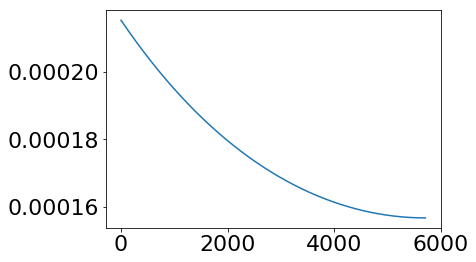

In [82]:
x_t = np.array([np.cos(1),np.sin(1)])

M = np.array([[np.cos(t),np.sin(t)] for t in np.arange(1,np.pi/2,0.0001)])

for g in [1,]:
  kernel = lambda m: np.exp(g*np.linalg.norm(x_t-m)**2)
  K = np.array([kernel(m) for m in M])
  K = K/np.sum(K)
  K = sorted(K)
  K.reverse()
  plt.plot(K)

Text(0.5,1,'x_t - m_t')

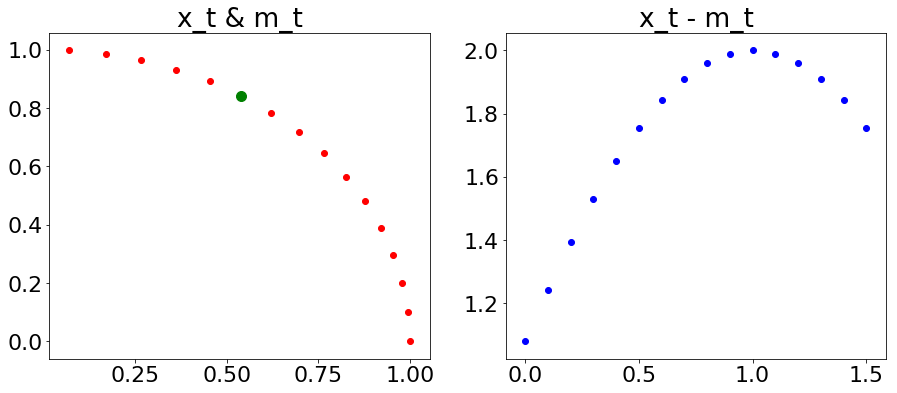

In [3]:
# compute w from k(m_i,x_t)

m1 = np.array([np.cos(1),np.sin(1)])

fig,axarr = plt.subplots(1,2,figsize=(15,6))
for t in np.arange(0,np.pi/2,0.1):
  x_t = np.array([np.cos(t),np.sin(t)])
  axarr[0].scatter(x_t[0],x_t[1],c='r')
  k = 2-np.linalg.norm(x_t-m1)**2
  axarr[1].scatter(t,k,c='b')
  
axarr[0].scatter(m1[0],m1[1],c='g',s=100)
axarr[0].scatter(m2[0],m2[1],c='g',s=100)

axarr[0].set_title('x_t & m_t')
axarr[1].set_title('x_t - m')

In [ ]:
np.linalg.norm()